In [22]:
import random
import torch
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_tabnet.tab_model import TabNetRegressor

df = pd.read_csv('csv/scoreboard_2025.csv')

In [24]:
# filter if column "team" = "한화"
df_hanwha = df[df["team"] == "한화"]
print(df_hanwha)

              idx team  result  i_1  i_2  i_3  i_4 i_5 i_6 i_7  ... day week  \
9     20250308004   한화      -1    1    0    0    0   0   1   0  ...   8    5   
19    20250309004   한화      -1    0    0    0    1   1   0   0  ...   9    6   
20    20250310004   한화       1    0    0    1    2   0   0   0  ...  10    0   
30    20250311004   한화       1    1    1    1    5   0   0   0  ...  11    1   
42    20250313004   한화       0    0    1    0    0   2   0   0  ...  13    3   
...           ...  ...     ...  ...  ...  ...  ...  ..  ..  ..  ...  ..  ...   
1546  20251026004   한화      -1    0    0    0    0   0   2   0  ...  26    6   
1548  20251027004   한화      -1    4    0    0    1   0   0   0  ...  27    0   
1551  20251029004   한화       1    0    1    0    0   0   0   0  ...  29    2   
1553  20251030004   한화      -1    0    0    0    1   0   0   2  ...  30    3   
1555  20251031004   한화      -1    0    1    0    0   0   0   0  ...  31    4   

     home away dbheader place audience 

In [25]:
from statsmodels.tsa.seasonal import STL

In [26]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller  # 정상성 검정을 위한 함수
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf as acf_func

month
3     3.375000
4     4.791667
5     4.360000
6     4.666667
7     5.190476
8     4.000000
9     6.833333
10    5.166667
Name: r, dtype: float64
month
5    -1.848333
6     0.738333
7     0.217143
8    -1.714286
9     4.023810
10   -4.500000
Name: r, dtype: float64


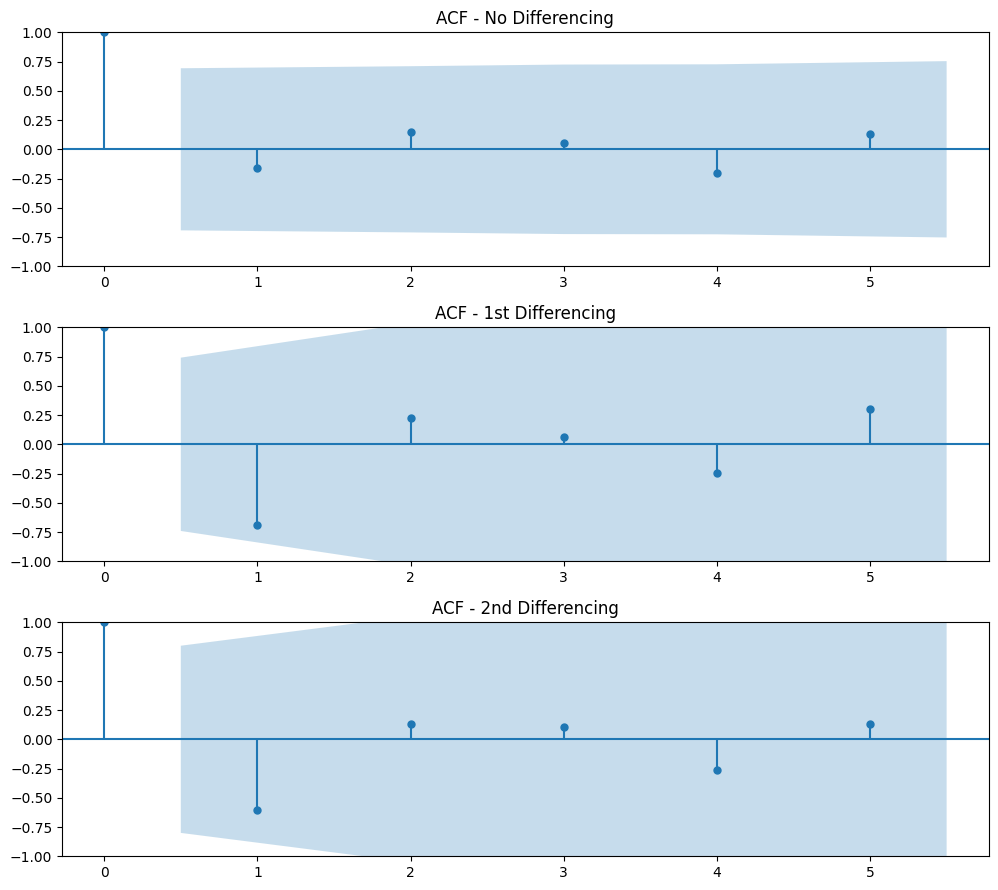

Significant lags (no differencing): []
Significant lags (1st diff): []
Significant lags (2nd diff): []
Lags significant in all correlograms: []


In [34]:
# idx = "20250513004" "시합날짜+더블헤더+팀ID"로 구성된 기본 키. 선수들 정보와 경기 정보를 연결한다. 2025.05.13, non doubleheader, home team = 한화(04)
# I want to group by month and see the trend of hanwha team score

monthly = df_hanwha.groupby('month')['r'].mean().sort_index()

s0 = monthly.astype(float)  # 차분 0회: 원본 데이터
s1 = s0.diff().dropna()  # 차분 1회: 현재 값 - 이전 값 (변화량)
s2 = s1.diff().dropna()  # 차분 2회: 변화량의 변화 (가속도)
print(monthly)
print(s2)

n_lags = min(24, len(s2) - 1)
import matplotlib.pyplot as plt

# 3개의 서브플롯(그래프)을 만듭니다
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
# 각 차분 단계별로 ACF 그래프를 그립니다 (최대 24개월까지)
plot_acf(s0, lags=n_lags, ax=axes[0], title='ACF - No Differencing')
plot_acf(s1, lags=n_lags, ax=axes[1], title='ACF - 1st Differencing')
plot_acf(s2, lags=n_lags, ax=axes[2], title='ACF - 2nd Differencing')
plt.tight_layout()  # 그래프 간격을 자동으로 조정
plt.show()

# 통계적으로 유의미한 lag들을 찾는 함수를 정의합니다
def significant_lags(series, nlags=24, alpha=0.05):
    # ACF 값과 신뢰구간을 계산합니다 (alpha=0.05는 95% 신뢰수준)
    acf_vals, confint = acf_func(series, nlags=nlags, alpha=alpha)
    sig = []  # 유의미한 lag들을 저장할 리스트
    # 각 lag에 대해 신뢰구간을 확인합니다
    for lag in range(1, len(acf_vals)):
        lower = confint[lag][0]  # 신뢰구간 하한
        upper = confint[lag][1]  # 신뢰구간 상한
        # 신뢰구간이 0을 포함하지 않으면 유의미한 것으로 판단
        if (lower > 0) or (upper < 0):
            sig.append(lag)
    return acf_vals, confint, sig

# 각 차분 단계별로 유의미한 lag들을 찾습니다
acf0, conf0, sig0 = significant_lags(s0)  # 차분 0회
acf1, conf1, sig1 = significant_lags(s1)  # 차분 1회
acf2, conf2, sig2 = significant_lags(s2)  # 차분 2회

# 결과를 출력합니다
print("Significant lags (no differencing):", sig0)
print("Significant lags (1st diff):", sig1)
print("Significant lags (2nd diff):", sig2)

# 모든 차분 단계에서 공통적으로 유의미한 lag들을 찾습니다
common = sorted(list(set(sig0) & set(sig1) & set(sig2)))
print("Lags significant in all correlograms:", common)

In [ ]:
# STL 분해를 수행하는 함수를 불러옵니다
# STL: Seasonal and Trend decomposition using Loess
from statsmodels.tsa.seasonal import STL
# 추가로 필요한 함수들을 불러옵니다
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller  # 정상성 검정을 위한 함수


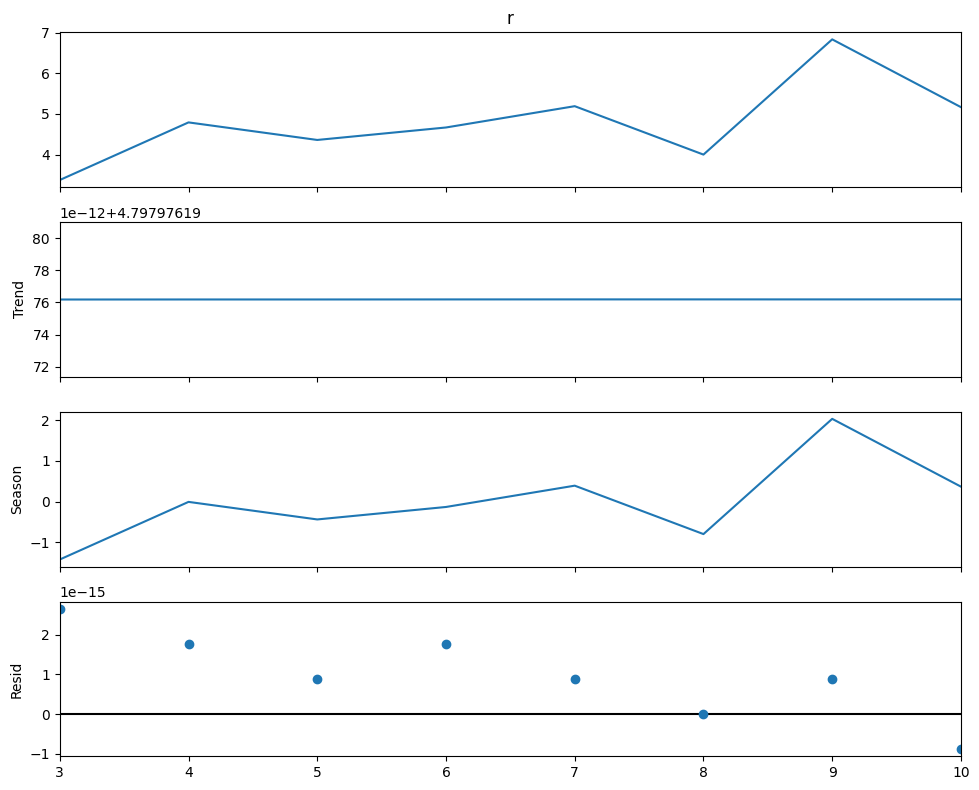

ADF statistic: -1.2074, p-value: 0.6704
Critical values:
  1%: -6.0451
  5%: -3.9293
  10%: -2.9868
Residuals do NOT appear stationary (fail to reject H0 at 5% level).


In [36]:
# STL 분해를 수행합니다
# period=12: 12개월(1년) 주기의 계절성을 찾습니다
# robust=True: 이상치에 강건한 방법을 사용합니다
stl = STL(monthly, period=8, robust=True)
res = stl.fit()  # 모델을 실행합니다

# 분해 결과를 그래프로 표시합니다
# 4개 그래프: 원본 데이터, 추세, 계절성, 잔차
fig = res.plot()
fig.set_size_inches(10, 8)  # 그래프 크기 설정
plt.tight_layout()  # 레이아웃 조정
plt.show()

# 잔차(residual)의 정상성을 검정합니다
resid = res.resid.dropna()  # 결측값 제거
# ADF(Augmented Dickey-Fuller) 테스트: 정상성을 검정하는 통계 테스트
adf_stat, pval, usedlag, nobs, crit_vals, icbest = adfuller(resid)

# 테스트 결과를 출력합니다
print(f"ADF statistic: {adf_stat:.4f}, p-value: {pval:.4f}")
print("Critical values:")  # 임계값들 (비교 기준)
for k, v in crit_vals.items():
    print(f"  {k}: {v:.4f}")

# p-value가 0.05보다 작으면 정상성이 있다고 판단합니다
if pval < 0.05:
    print("Residuals appear stationary (reject H0 of a unit root at 5% level).")
else:
    print("Residuals do NOT appear stationary (fail to reject H0 at 5% level).")